In [20]:
import os
import h5py
import json
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [161]:
def load_json(json_path):
    with open(json_path, 'r') as f:
        json_file = json.load(f)
    return json_file

class dataLoader():
    def __init__(self, params):
        
        self.img_dir = params['img_dir']
        
        # load numpy data
        h5py_file = h5py.File(params['h5py_path'], 'r')
        self.caption_labels = h5py_file['/caption_labels']
        self.caption_length = h5py_file['/caption_length']
        #h5py_file.close()
        
        # load json data
        json_file = load_json(params['json_path'])
        self.wtoi = json_file['wtoi']
        self.itow = json_file['itow']
        self.caption_ids = json_file['caption_ids']
        self.image_ids = json_file['image_ids']
        self.image_path = json_file['image_path']
        self.max_caption_length = json_file['max_caption_length']
        
        # set iterator
        self.iter_idx = 0
        self.num_captions = len(self.caption_ids)
        self.vgg_mean = np.array([123.68, 116.779, 103.939])
    
    def getWtoi(self):
        return self.wtoi
    
    def getItow(self):
        return self.itow
    
    def getMaxCaptionLength(self):
        return self.max_caption_length
    
    def resetIterIndex(self):
        self.iter_idx = 0
    
    def incrementIterIndex(self):
        self.iter_idx += 1
    
    def getBatch(self, batch_size=50):
        
        batch_caption_length = np.zeros(batch_size, dtype='uint32')
        batch_caption_labels = np.zeros((batch_size, self.max_caption_length), dtype='uint32')
        batch_caption_masks = np.zeros((batch_size, self.max_caption_length), dtype='uint32')
        batch_images = np.zeros((batch_size, 224, 224, 3), dtype='float')
        batch_image_path = []
        batch_question_ids = []
        
        for bi in range(batch_size):
            if self.iter_idx == self.num_captions:
                self.resetIterIndex()
                
            # load caption label and length
            cap_length = self.caption_length[self.iter_idx]
            batch_caption_length[bi] = cap_length
            batch_caption_labels[bi] = self.caption_labels[self.iter_idx]
            batch_caption_masks[bi, :cap_length] = 1
            
            # load and preprocessing an image
            img = Image.open(self.img_dir + self.image_path[self.iter_idx]).convert('RGB') #(224,224,3)
            img = np.array(img, 'f')
            for i in range(3): img[:,:,i] = img[:,:,i] - self.vgg_mean[i]
            #img = np.transpose(img, [2,0,1]) # (224,224,3) -> (3,224,224)
            batch_images[bi] = img
            
            # load caption id
            batch_question_ids.append(self.caption_ids[self.iter_idx])
            
            # increment iterator
            self.incrementIterIndex()
            
        batch = {}
        batch['caption_labels'] = batch_caption_labels
        batch['caption_length'] = batch_caption_length
        batch['caption_masks'] = batch_caption_masks
        batch['images'] = batch_images
        batch['question_ids'] = batch_question_ids 
        
        return batch    

In [175]:
params = {
    'json_path':'resource/train.json',
    'h5py_path':'resource/train.h5',
    'img_dir': 'resource/224x224_mscoco_images/'
}

loader = dataLoader(params)
itow = loader.getItow()
batch = loader.getBatch()
vgg_mean = np.array([123.68, 116.779, 103.939])

In [191]:
print(np.max(batch['images']))
print(np.min(batch['images']))

151.061004639
-123.680000305


### show batch data

caption label :  [   3    1 1879    6  165  732   10  205   21 1447   22   13  153   80    2]
caption mask  :  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
caption length:  15
caption       :  <S> a series of parking meters and cars are located next to each other <E> 


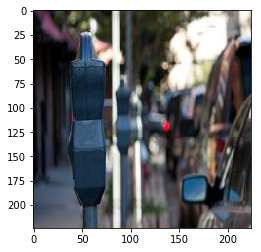

In [210]:
idx = random.randint(0,49)
img = np.copy(batch['images'][idx])
for i in range(3): img[:,:,i] = img[:,:,i] + vgg_mean[i]
caption = batch['caption_labels'][idx]
mask = batch['caption_masks'][idx]
length = batch['caption_length'][idx]

# print caption label, mask and length
print('caption label : ', caption)
print('caption mask  : ', mask)
print('caption length: ', length)

# caption label to caption string
cap = ''
for i in range(15):
    w = itow[str(caption[i])]
    if w == '<E>':
        cap += (w + ' ')
        break
    else:
        cap += (w + ' ')
print('caption       : ', cap)

# show image
plt.imshow(img/255.)
plt.show()   
    